Install py21cmfast (https://21cmfast.readthedocs.io/) to model reionization with 21cmFAST.
Generating uv map from daily observations...


Gridding uv tracks: 2160it [00:05, 364.82it/s]


...done
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 4613.32it/s]


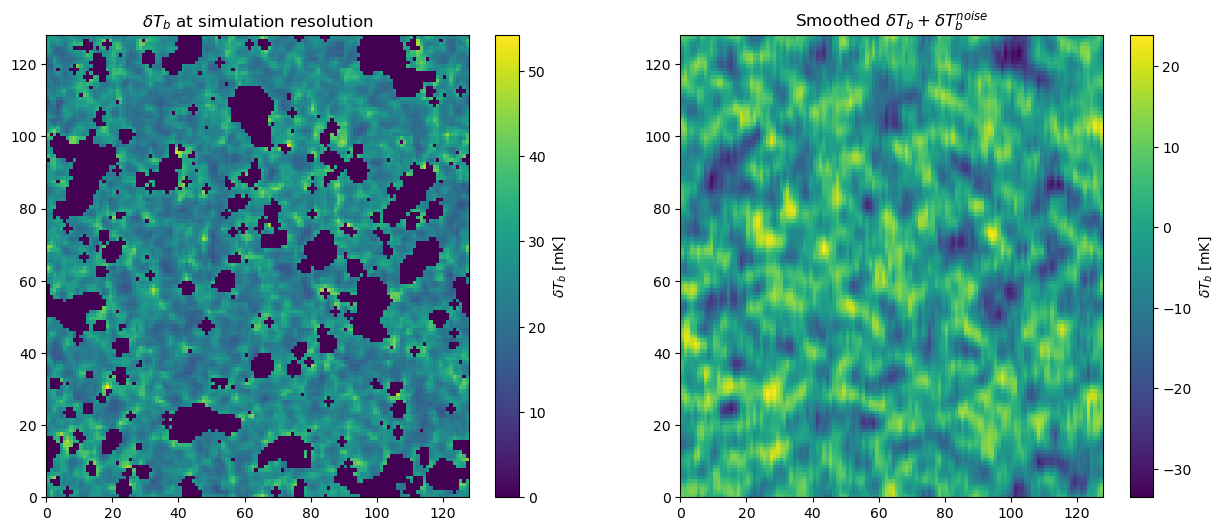

In [1]:
import numpy as np
import tools21cm as t2c
import matplotlib.pyplot as plt

# Load your data
dT = np.load("SegUNetdata/dT_z9.868.npy")

# Define observation parameters
z = 9.868  # Redshift
boxsize = 244 / 0.7  # Box size in Mpc (example value)

# Calculate UV coverage
uv, Nant = t2c.get_uv_daily_observation(
    ncells=dT.shape[0],
    z=z,
    filename=None,  # Uses default SKA-Low 2016 configuration if None
    total_int_time=6.0,  # Observation time per day in hours
    int_time=10.0,  # Integration time in seconds
    boxsize=boxsize,
    declination=-30.0,
    verbose=True
)

# Generate noise cube
noise_cube = t2c.noise_cube_coeval(
    ncells=dT.shape[0],
    z=z,
    depth_mhz=None,  
    obs_time=1000,  
    filename=None,
    boxsize=boxsize,
    total_int_time=6.0,
    int_time=10.0,
    declination=-30.0,
    uv_map=uv,
    N_ant=Nant,
    verbose=True,
    fft_wrap=False
)

# Subtract the mean signal
dT_mean = np.mean(dT)
dT_subtracted = dT - dT_mean

# Combine the mean-subtracted signal with the noise
dT2 = dT_subtracted + noise_cube

# Apply instrumental smoothing
dT_smooth = t2c.smooth_coeval(
    cube=dT2,
    z=z,
    box_size_mpc=boxsize,
    max_baseline=2.0,  # Maximum baseline of the telescope in km
    ratio=1.0,  # Ratio of smoothing scale in frequency direction
    nu_axis=2  # Frequency axis
)

# Visualization
plt.rcParams['figure.figsize'] = [15, 6]

plt.subplot(121)
plt.title('$\delta T_b$ at simulation resolution')
plt.pcolormesh(dT[0])
plt.colorbar(label='$\delta T_b$ [mK]')

plt.subplot(122)
plt.title('Smoothed $\delta T_b + \delta T^{noise}_b$')
plt.pcolormesh(dT_smooth[0])
plt.colorbar(label='$\delta T_b$ [mK]')

plt.show()


In [2]:
import numpy as np
import tools21cm as t2c
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

# Ensure the data is in the correct format
# Extract a 128^3 sub-cube if necessary
dT_cut = dT_smooth[:128, :128, :128]

# Initialize the SegU-Net model with Test-Time Augmentation (TTA) level
seg = t2c.segmentation.segunet21cm(tta=2, verbose=True)

# Predict the ionization map and pixel-wise uncertainty
xHI_seg, xHI_seg_err = seg.prediction(x=dT_cut)

# If you have a ground truth mask, you can evaluate the prediction
# For example, using the Matthews correlation coefficient
# mask_xHI = np.load("path_to_ground_truth_mask.npy")
# mask_xHI2 = mask_xHI[:128, :128, :128]
# phicoef_seg = matthews_corrcoef(mask_xHI2.flatten(), xHI_seg.flatten())

# Visualization
plt.rcParams['figure.figsize'] = [12, 6]

plt.subplot(121)
plt.title('SegU-Net Predicted Ionization Map')
plt.imshow(xHI_seg[0], origin='lower', cmap='jet')
plt.colorbar(label='Ionization Fraction')

plt.subplot(122)
plt.title('SegU-Net Pixel-Wise Uncertainty')
plt.imshow(xHI_seg_err[0], origin='lower', cmap='jet')
plt.colorbar(label='Uncertainty')

plt.show()

tot number of (unique) manipulation we can do on a cube: 28


AttributeError: module 'importlib.resources' has no attribute 'resource_filename'

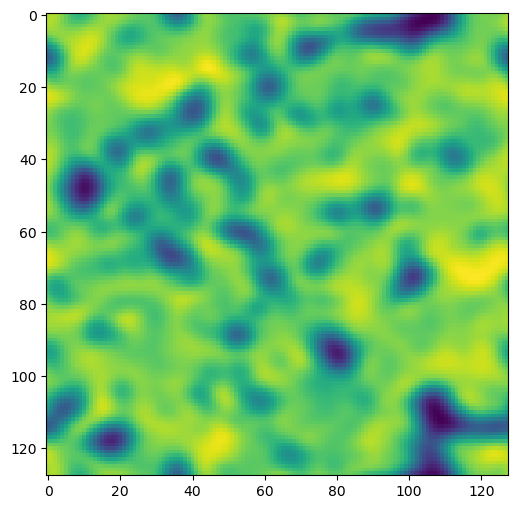

In [11]:
# Load your data
xH = np.load("SegUNetdata/dT2_z9.868.npy")
plt.imshow(xH[:,:,64],cmap="viridis")